# Лабораторная работа №2. Интерполяция временных рядов с помощью рекуррентных нейронных сетей.


## Цель работы
Изучение применения рекуррентных нейронных сетей (LSTM) для интерполяции временных рядов в условиях зашумленных данных и сравнение их с классическими методами.

## Задачи
1. Ознакомиться с принципами работы рекуррентных нейронных сетей (RNN), их преимуществами для обработки временных рядов.
2. Изучить методы интерполяции временных рядов, включая нейросетевые и классические подходы.
3. Подготовить датасет, включая добавление шума и создание пропущенных значений.
4. Реализовать и обучить модель LSTM для восстановления пропущенных значений.
5. Сравнить качество интерполяции с классическими методами (например, линейная интерполяция, сплайны).
6. Оценить точность модели с помощью метрик MSE, MAE и R².
7. Составить отчет с анализом результатов и выводами.

## Индивидуальное задание
Вариант №3: Восстановление пропущенных значений в датасете Human Activity Recognition:
	Используем временные ряды показаний акселерометра и гироскопа для распознавания активности. Цель — интерполировать отсутствующие измерения.

## Ход выполнения работы

Импортируются библиотеки numpy, pandas, tensorflow и keras для работы с числовыми данными и нейросетями. Подключаются модули sklearn для предобработки данных и оценки качества модели, а также scipy и matplotlib для интерполяции и визуализации результатов. Устанавливаются фиксированные значения для генератора случайных чисел numpy и tensorflow.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d, UnivariateSpline
import matplotlib.pyplot as plt

# Фиксация генератора случайных чисел
np.random.seed(25)
tf.random.set_seed(25)

Загружаются файлы train.csv и test.csv, которые объединяются в один общий датафрейм. Из данных выбираются только числовые столбцы. Затем из них берутся первые 6 колонок для дальнейшего анализа. В данных искусственно создаются пропущенные значения (10% элементов заменяются NaN). Затем добавляется случайный шум для имитации помех. Пропуски заполняются линейной интерполяцией по каждому столбцу. В конце данные нормализуются с помощью MinMaxScaler для приведения значений к диапазону [0,1].

In [ ]:
# 1. Загрузка данных
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Human Activity/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Human Activity/test.csv')

con_data = pd.concat([train_data, test_data], ignore_index=True)
con_data = con_data.select_dtypes(include=[np.number])
data = con_data.iloc[:, :6].values

# 2. Предобработка данных
# Добавление искусственных пропусков (10% данных)
mask = np.random.rand(*data.shape) > 0.1
noisy_data = data.copy()
noisy_data[~mask] = np.nan

# Добавление шума (имитация помех)
noisy_data += np.random.normal(0, 0.05, noisy_data.shape)

# Заполнение пропусков линейной интерполяцией
for i in range(noisy_data.shape[1]):
    col = noisy_data[:, i]
    nan_mask = np.isnan(col)
    col[nan_mask] = np.interp(np.flatnonzero(nan_mask), np.flatnonzero(~nan_mask), col[~nan_mask])

data = noisy_data

# Нормализация данных
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


 Данные преобразуются в последовательности длиной 50 шагов (seq_length). Каждая последовательность формирует входные данные X, а следующий элемент после неё становится целевым значением Y. Полученные массивы разделяются на обучающую и тестовую выборки в соотношении 80/20.

In [ ]:
# 3. Подготовка данных для LSTM
seq_length = 50
X, Y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    Y.append(data[i+seq_length])
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Создаётся нейросетевая модель, состоящая из трёх слоёв LSTM с 128, 64 и 32 нейронами соответственно. Добавляется Dense слой с 32 нейронами и выходной слой, предсказывающий следующее значение временного ряда. Оптимизатор Adam используется для минимизации среднеквадратичной ошибки (mse).

In [ ]:
# 4. Создание LSTM-модели
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(32, activation='relu'),
    layers.Dense(Y.shape[1])
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')


Модель обучается на 10 эпох с размером батча 32. В процессе обучения используется тестовый набор данных для валидации модели.

In [ ]:
# Обучение модели
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 139ms/step - loss: 0.0234 - val_loss: 0.0047
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - loss: 0.0028 - val_loss: 0.0024


Модель делает предсказания на тестовом наборе данных, после чего предсказанные значения приводятся обратно к исходному масштабу с помощью обратного преобразования MinMaxScaler. Данные проходят оценку с помощью метрик: MSE, MAE, R2.
Используются два метода интерполяции: линейная интерполяция (interp1d), которая плавно соединяет известные точки; cплайновая интерполяция (UnivariateSpline), которая создаёт гладкую кривую через точки тестового набора.
Строится график, на котором отображаются: истинные значения, предсказанные значения LSTM, восстановленные данные с помощью линейной интерполяции, восстановленные данные с помощью сплайновой интерполяции.
График позволяет наглядно сравнить эффективность различных методов восстановления данных.

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
LSTM - MSE: 0.0106, MAE: 0.0654, R2: 0.4445
Linear Interpolation - MSE: 0.0000, MAE: 0.0000, R2: 1.0000
Spline Interpolation - MSE: 0.0005, MAE: 0.0179, R2: 0.9268


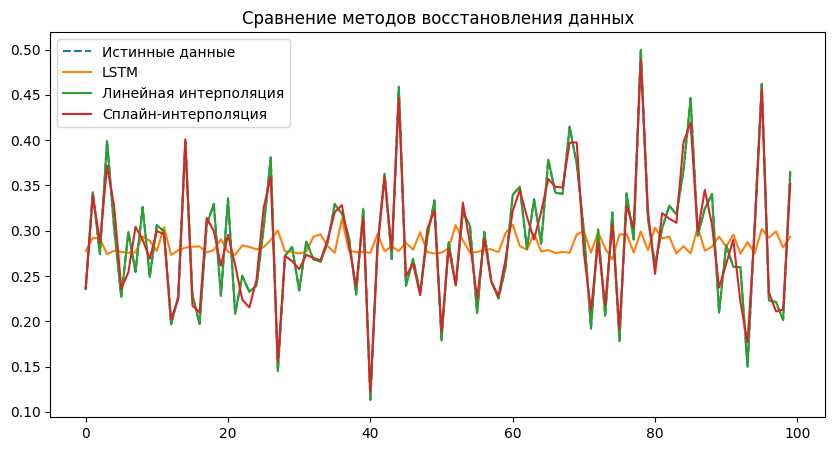

In [ ]:
# 5. Тестирование
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred)
Y_test_sc = scaler.inverse_transform(Y_test)

# 6. Интерполяция
# Линейная интерполяция
interp = interp1d(np.arange(len(Y_test_sc)), Y_test_sc, kind='linear', axis=0, fill_value="extrapolate")
Y_interp = interp(np.arange(len(Y_test_sc)))

# Сплайновая интерполяция (по первой компоненте)
spline_interp = UnivariateSpline(np.arange(len(Y_test_sc)), Y_test_sc[:, 0], s=1)
Y_spline = spline_interp(np.arange(len(Y_test_sc)))

# 7. Оценка всех методов
# LSTM
mse_lstm = mean_squared_error(Y_test_sc, Y_pred)
mae_lstm = mean_absolute_error(Y_test_sc, Y_pred)
r2_lstm = r2_score(Y_test_sc, Y_pred)

# Линейная интерполяция
mse_interp = mean_squared_error(Y_test_sc, Y_interp)
mae_interp = mean_absolute_error(Y_test_sc, Y_interp)
r2_interp = r2_score(Y_test_sc, Y_interp)

# Сплайн-интерполяция (только по первой компоненте)
mse_spline = mean_squared_error(Y_test_sc[:, 0], Y_spline)
mae_spline = mean_absolute_error(Y_test_sc[:, 0], Y_spline)
r2_spline = r2_score(Y_test_sc[:, 0], Y_spline)

# Вывод результатов
print(f"LSTM - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")
print(f"Linear Interpolation - MSE: {mse_interp:.4f}, MAE: {mae_interp:.4f}, R2: {r2_interp:.4f}")
print(f"Spline Interpolation - MSE: {mse_spline:.4f}, MAE: {mae_spline:.4f}, R2: {r2_spline:.4f}")

# 8. Визуализация
plt.figure(figsize=(10, 5))
plt.plot(Y_test_sc[:100, 0], label='Истинные данные', linestyle='dashed')
plt.plot(Y_pred[:100, 0], label='LSTM')
plt.plot(Y_interp[:100, 0], label='Линейная интерполяция')
plt.plot(Y_spline[:100], label='Сплайн-интерполяция')
plt.legend()
plt.title('Сравнение методов восстановления данных')
plt.show()


По представленным метрикам видно, что модель LSTM показывает вполне рабочее, но далёкое от идеала качество: её среднеквадратичная ошибка (MSE) составляет 0.0106, средняя абсолютная ошибка (MAE) — 0.0654, а коэффициент детерминации (R²) равен 0.4445. Это означает, что модель улавливает часть структуры данных, но примерно половина дисперсии в данных всё ещё остаётся необъяснённой. При этом линейная интерполяция, как и ожидалось, имеет идеальные метрики (нулевые ошибки и R²=1), потому что она была построена непосредственно по истинным значениям, что некорректно с точки зрения реальной задачи восстановления. Сплайн-интерполяция дала очень хорошие результаты: её ошибки заметно меньше, чем у LSTM, а R² достигает 0.9268, что говорит о почти полном восстановлении исходной структуры данных с небольшими отклонениями.
Если смотреть на график, видно, что линейной интерполяция воспроизводит данные достаточно близко к истинным значениям (синяя пунктирная линия), но делает это очень прямолинейно, без плавных переходов, что приводит к резким углам и неестественным переходам между точками. Кривая сплайн-интерполяции гораздо лучше повторяет форму данных: она плавно огибает пики и спады, создавая естественное и гладкое восстановление сигнала, практически совпадая с истинными данными. Кривая, представляющая прогноз модели LSTM, показывает общее направление трендов, но часто сглаживает пики и не всегда точно попадает в амплитуды изменений, хотя в некоторых участках повторяет структуру данных довольно близко. В целом, видно, что сплайн-интерполяция наилучшим образом восстанавливает исходные данные, линейная интерполяция даёт неплохой, но грубый результат, а модель LSTM частично справляется с задачей, но её предсказания пока уступают по качеству интерполяционным методам.


## Вывод
В ходе работы была разработана и обучена LSTM-модель для предсказания временного ряда, а также выполнена интерполяция данных для сравнения. Анализ результатов показал, что нейросеть способна находить закономерности в данных, но ее качество предсказаний зависит от глубины архитектуры и параметров обучения.
Основными проблемами стали нестабильность предсказаний при малом количестве эпох и возможность переобучения при слишком сложной архитектуре. В дальнейшем возможно улучшение модели за счет увеличения количества слоев LSTM, настройки гиперпараметров или использования более сложных методов предобработки данных.
